<a href="https://colab.research.google.com/github/yongtaoliu/Physics--cVAE/blob/main/Notebook1_1DPeak_Physics_%3EVAE_cont_VAE_r1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning VAE on a continuous "property" vector

Notes:


March, 2022

- Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- Pyroved developed by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- Analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

Package Version:


*   pyroved: 0.2.3
*   numpy: 1.21.5
*   torch: 1.10.0+cu111


# **Install pyroVED package:**

In [1]:
!pip install git+https://github.com/ziatdinovmax/pyroved

  Cloning https://github.com/ziatdinovmax/pyroved to /tmp/pip-req-build-6xy17m_z
  Running command git clone -q https://github.com/ziatdinovmax/pyroved /tmp/pip-req-build-6xy17m_z
     |████████████████████████████████| 713 kB 7.1 MB/s 
  Created wheel for pyroved: filename=pyroved-0.2.3-py3-none-any.whl size=46255 sha256=a7dad75ee8668826ef0cb17623275292e2c0e1f911b572f61ded536cff2ce103
  Stored in directory: /tmp/pip-ephem-wheel-cache-20yygloy/wheels/8a/c0/fd/789c9c3290ecff8fd3f1ecb40f758149a91ce6732530676285
Successfully built pyroved


# **Imports:**

In [2]:
import pyroved as pv
import torch
import numpy as np
import matplotlib.pyplot as plt

### First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise.

In [3]:
# Define 1D_Spectra Generation Function with various mu, sig, and a
def gaussian(x, mu, sig):
    x, mu, sig = torch.tensor(x), torch.tensor(mu), torch.tensor(sig)
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

def generate_1Dspectra(nsamples: int = 3000, a_real1=50, a_real2=100, mu_real1=-30, mu_real2=30, sig_real1=50, sig_real2=500) -> torch.Tensor:
    x = torch.linspace(-10, 10, 100)                            

    dataset = []
    mu_real = []
    sig_real = []
    a_real = []

    for _ in range(nsamples):
        noise = torch.randint(0, 30, (1,)) / 1e3              
        mu = torch.randint(mu_real1 ,mu_real2, size = (1,)) / 10            
        sig = torch.randint(sig_real1, sig_real2, size=(1,)) / 1e2          
        a = torch.randint(a_real1, a_real2, size=(1,)) / 100             

        g = a*gaussian(x, mu, sig) + noise * torch.randn(size=(len(x),))

        dataset.append(g[None, ...])
        mu_real.append(mu)
        sig_real.append(sig)
        a_real.append(a)

    dataset = torch.cat(dataset)
    mu_real = torch.cat(mu_real)
    sig_real = torch.cat(sig_real)
    a_real = torch.cat(a_real)

    dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
    return dataset, mu_real, a_real, sig_real

### Generate a data set

In [4]:
train_data, mu_real, a_real, sig_real = generate_1Dspectra(a_real1 = 30, a_real2= 100, mu_real1 = -30, mu_real2 = 30, sig_real1 = 50, sig_real2 = 200)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Plot a few example data

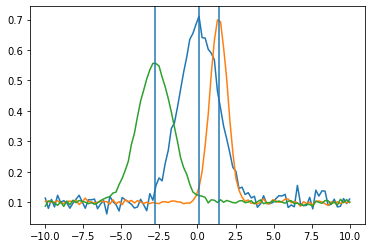

In [5]:
x = torch.linspace(-10, 10, 100) 

plt.plot(x,train_data[0])
plt.plot(x,train_data[1000])
plt.plot(x,train_data[2000])
plt.axvline(mu_real[0])
plt.axvline(mu_real[1000])
plt.axvline(mu_real[2000])

### Prepare training data

In [6]:
mu_real = torch.reshape(mu_real, (-1, 1))
a_real = torch.reshape(a_real, (-1, 1))
sig_real = torch.reshape(sig_real, (-1, 1))

Initialize train loader

In [7]:
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), mu_real, batch_size=64)

Show the training dataset

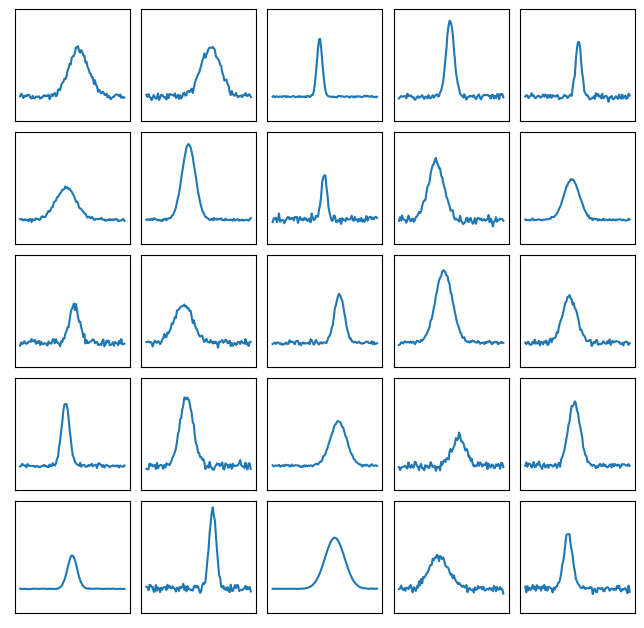

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1), dpi = 100)

x = torch.linspace(-10, 10, 100)
for ax, (y, m) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])
    ax.set_ylim(-0.15, 1.0)


## **Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about shifts as our $c$ vector.**

In [9]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae1)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -43.3655
Epoch: 2 Training loss: -104.6254
Epoch: 3 Training loss: -117.3963
Epoch: 4 Training loss: -121.7123
Epoch: 5 Training loss: -124.2327
Epoch: 6 Training loss: -125.3652
Epoch: 7 Training loss: -126.0328
Epoch: 8 Training loss: -126.3046
Epoch: 9 Training loss: -126.5905
Epoch: 10 Training loss: -126.6622
Epoch: 11 Training loss: -127.0765
Epoch: 12 Training loss: -127.1629
Epoch: 13 Training loss: -127.5142
Epoch: 14 Training loss: -127.5784
Epoch: 15 Training loss: -127.6642
Epoch: 16 Training loss: -128.1896
Epoch: 17 Training loss: -128.2985
Epoch: 18 Training loss: -128.4930
Epoch: 19 Training loss: -128.6439
Epoch: 20 Training loss: -128.5791
Epoch: 21 Training loss: -128.7173
Epoch: 22 Training loss: -128.8651
Epoch: 23 Training loss: -128.8411
Epoch: 24 Training loss: -128.9394
Epoch: 25 Training loss: -129.0862
Epoch: 26 Training loss: -128.8989
Epoch: 27 Training loss: -129.0709
Epoch: 28 Training loss: -129.0902
Epoch: 29 Training loss: -129.

Encode the training data into the latent space:

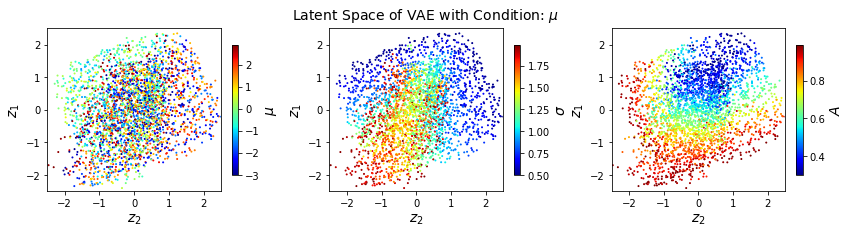

In [10]:
z_mean, z_sd = vae1.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE with Condition: $\mu$", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

Plot latent variables vs. ground truth

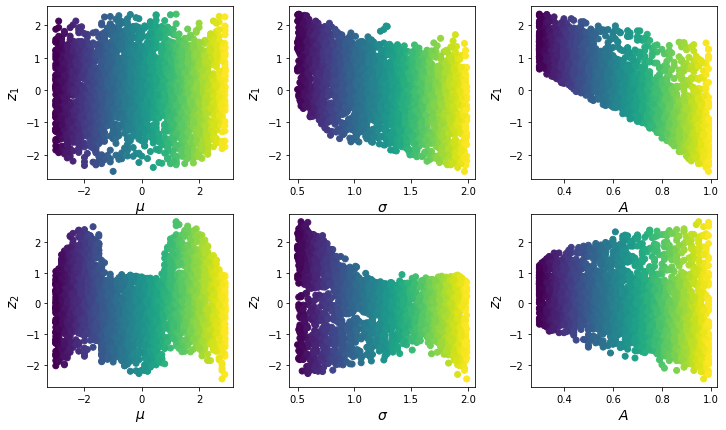

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], c=mu_real)
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], c=mu_real)
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], c=sig_real)
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], c=sig_real)
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], c=a_real)
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], c=a_real)
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Our data had three factors of variation, peak position, peak width, and peak intensity. By conditioning the model on the "known" property (shift) it was able to clearly identify the unknown ones (width and intensity). Notice that [without the conditioning](https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/master/examples/shiftVAE.ipynb?authuser=1#scrollTo=B_jDOtumPm4C&line=8&uniqifier=1), the two factors of variation wouldn't be completely disentangled.

Plot the learned latent manifolds conditioned on the shift:

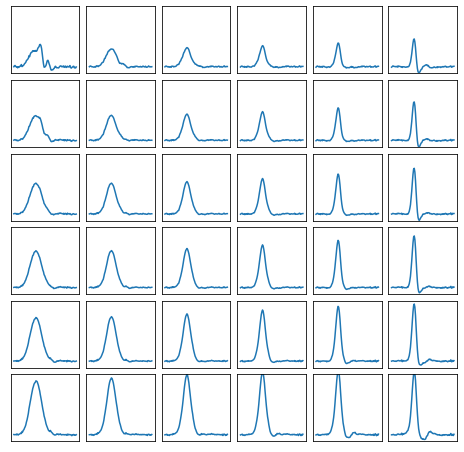

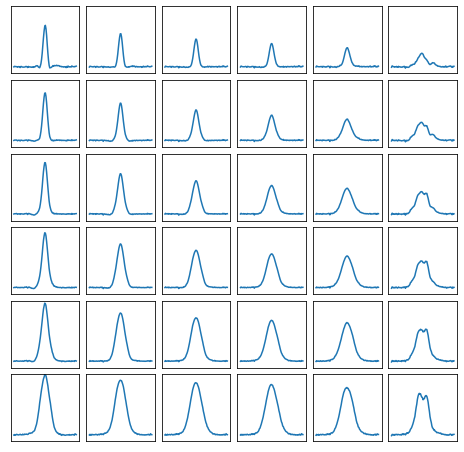

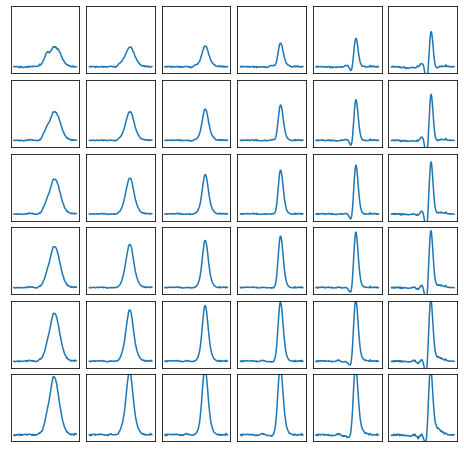

In [12]:
y_all = [-3, 0, 3]
for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    vae1.manifold2d(6, y, ylim = [0,1])

## Now let's condition on a 2-dimensional vector containing information on the peak shifts and widths.

In [13]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([mu_real, sig_real], -1), batch_size=64)

In [14]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=2 to add extra dimensions corresponding to c-vector to the decoder)
vae2 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=2, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)
# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae2)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()


Epoch: 1 Training loss: -57.3456
Epoch: 2 Training loss: -106.4937
Epoch: 3 Training loss: -114.8318
Epoch: 4 Training loss: -121.2816
Epoch: 5 Training loss: -125.0120
Epoch: 6 Training loss: -126.5431
Epoch: 7 Training loss: -127.7052
Epoch: 8 Training loss: -128.3472
Epoch: 9 Training loss: -128.6966
Epoch: 10 Training loss: -129.2075
Epoch: 11 Training loss: -129.4795
Epoch: 12 Training loss: -129.6147
Epoch: 13 Training loss: -129.9983
Epoch: 14 Training loss: -130.0823
Epoch: 15 Training loss: -130.3095
Epoch: 16 Training loss: -130.4701
Epoch: 17 Training loss: -130.5352
Epoch: 18 Training loss: -130.6882
Epoch: 19 Training loss: -130.8767
Epoch: 20 Training loss: -130.9129
Epoch: 21 Training loss: -131.0701
Epoch: 22 Training loss: -131.0388
Epoch: 23 Training loss: -131.0989
Epoch: 24 Training loss: -131.2326
Epoch: 25 Training loss: -131.3339
Epoch: 26 Training loss: -131.4458
Epoch: 27 Training loss: -131.4843
Epoch: 28 Training loss: -131.5499
Epoch: 29 Training loss: -131.

Encode the training data into the latent space:

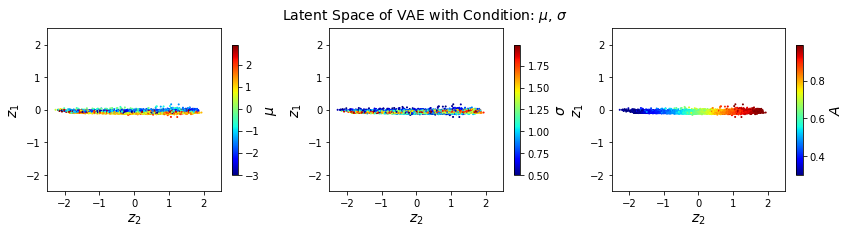

In [15]:
z_mean, z_sd = vae2.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE with Condition: $\mu$, $\sigma$", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

Plot latent variables vs. ground truth

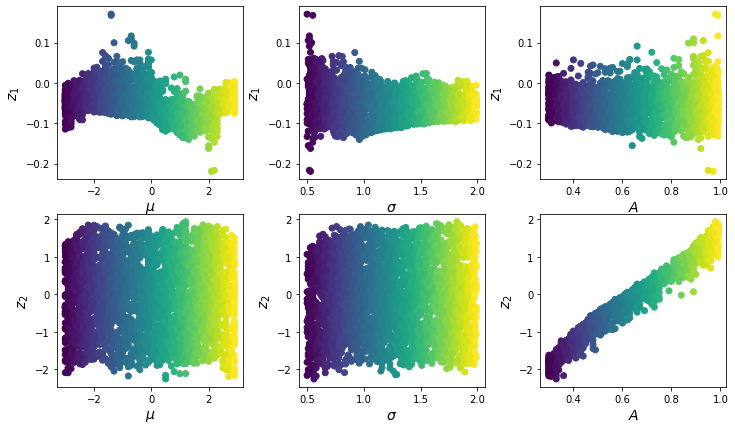

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], c=mu_real)
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], c=mu_real)
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], c=sig_real)
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], c=sig_real)
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], c=a_real)
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], c=a_real)
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Now let's condition on a 3-dimensional vector containing information on the peak shifts, widths, and intensity.

In [17]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(
    train_data.unsqueeze(1), torch.cat([mu_real, sig_real, a_real], -1), batch_size=64)

In [18]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae3 = pv.models.iVAE(in_dim, latent_dim=2, c_dim=3, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae3)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -61.2098
Epoch: 2 Training loss: -111.0368
Epoch: 3 Training loss: -120.3250
Epoch: 4 Training loss: -123.3313
Epoch: 5 Training loss: -125.2133
Epoch: 6 Training loss: -127.1003
Epoch: 7 Training loss: -128.5007
Epoch: 8 Training loss: -129.4382
Epoch: 9 Training loss: -130.0509
Epoch: 10 Training loss: -130.2575
Epoch: 11 Training loss: -130.7417
Epoch: 12 Training loss: -131.0068
Epoch: 13 Training loss: -131.2680
Epoch: 14 Training loss: -131.2406
Epoch: 15 Training loss: -131.4844
Epoch: 16 Training loss: -131.8425
Epoch: 17 Training loss: -131.8642
Epoch: 18 Training loss: -132.0580
Epoch: 19 Training loss: -132.2338
Epoch: 20 Training loss: -132.3167
Epoch: 21 Training loss: -132.4352
Epoch: 22 Training loss: -132.5695
Epoch: 23 Training loss: -132.6577
Epoch: 24 Training loss: -132.7528
Epoch: 25 Training loss: -132.7009
Epoch: 26 Training loss: -132.7960
Epoch: 27 Training loss: -132.9220
Epoch: 28 Training loss: -133.0141
Epoch: 29 Training loss: -133.

Encode the training data into the latent space:

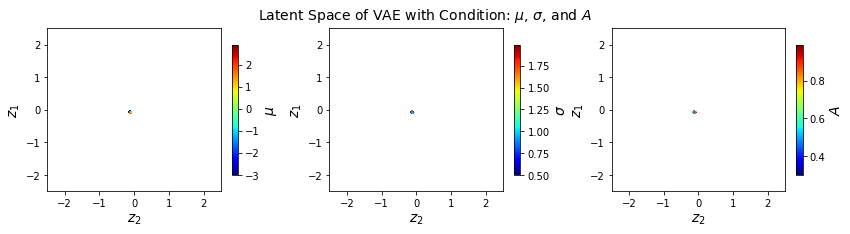

In [19]:
z_mean, z_sd = vae3.encode(train_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE with Condition: $\mu$, $\sigma$, and $A$", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

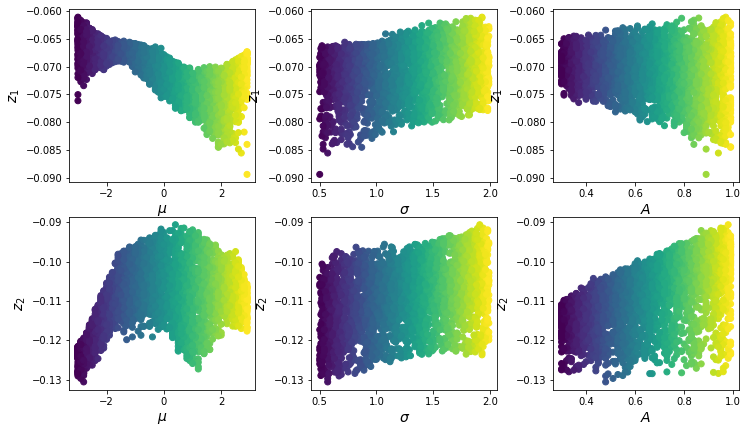

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], c=mu_real)
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], c=mu_real)
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], c=sig_real)
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], c=sig_real)
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], c=a_real)
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], c=a_real)
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Now let us do VAE and shift-VAE analyses as comparason 

In [21]:
# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

Train VAE model 

In [22]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae = pv.models.iVAE(in_dim, latent_dim=2, sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: -45.5989
Epoch: 2 Training loss: -105.6798
Epoch: 3 Training loss: -110.7408
Epoch: 4 Training loss: -116.6824
Epoch: 5 Training loss: -118.5694
Epoch: 6 Training loss: -119.4771
Epoch: 7 Training loss: -120.6587
Epoch: 8 Training loss: -121.3726
Epoch: 9 Training loss: -121.9233
Epoch: 10 Training loss: -122.2457
Epoch: 11 Training loss: -122.4844
Epoch: 12 Training loss: -122.6840
Epoch: 13 Training loss: -122.9286
Epoch: 14 Training loss: -122.9051
Epoch: 15 Training loss: -123.1453
Epoch: 16 Training loss: -123.2566
Epoch: 17 Training loss: -123.3391
Epoch: 18 Training loss: -123.5466
Epoch: 19 Training loss: -123.5424
Epoch: 20 Training loss: -123.5798
Epoch: 21 Training loss: -123.5875
Epoch: 22 Training loss: -123.5806
Epoch: 23 Training loss: -123.5333
Epoch: 24 Training loss: -123.8826
Epoch: 25 Training loss: -123.9218
Epoch: 26 Training loss: -123.8769
Epoch: 27 Training loss: -124.1128
Epoch: 28 Training loss: -124.0760
Epoch: 29 Training loss: -124.

Encode the training data into the latent space:

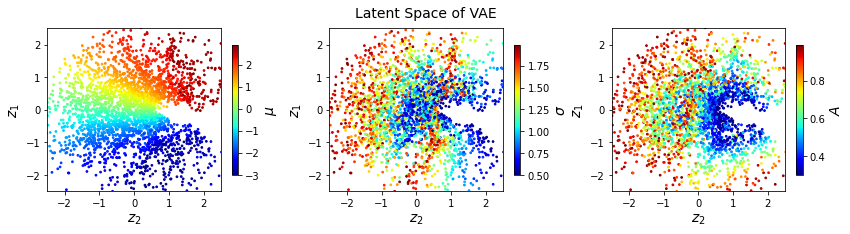

In [23]:
z_mean, z_sd = vae.encode(train_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of VAE", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

Plot latent variables vs. ground truth

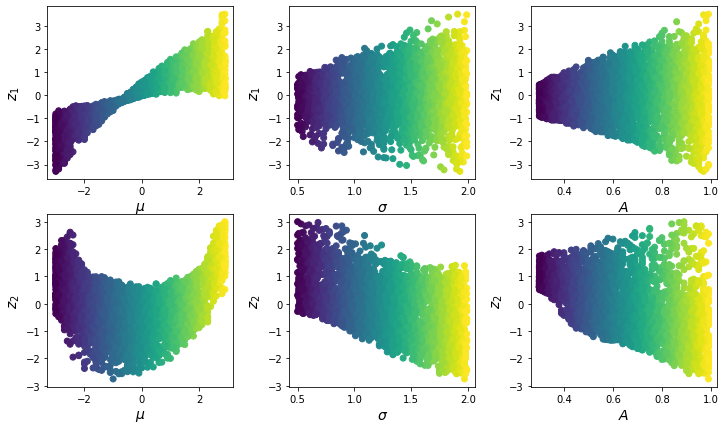

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], c=mu_real)
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], c=mu_real)
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], c=sig_real)
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], c=sig_real)
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], c=a_real)
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], c=a_real)
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

## Train shift-VAE model 

In [25]:
in_dim = (100,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
tvae = pv.models.iVAE(in_dim, latent_dim=2, invariances='t', sampler_d="gaussian",
                     sigmoid_d=False, decoder_sig=0.1)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(tvae)

# Train for n epochs:
for e in range(500):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 3.2918
Epoch: 2 Training loss: -45.6630
Epoch: 3 Training loss: -94.0249
Epoch: 4 Training loss: -115.8278
Epoch: 5 Training loss: -120.0592
Epoch: 6 Training loss: -121.5739
Epoch: 7 Training loss: -122.6107
Epoch: 8 Training loss: -122.9229
Epoch: 9 Training loss: -123.1776
Epoch: 10 Training loss: -123.6806
Epoch: 11 Training loss: -123.8655
Epoch: 12 Training loss: -124.0738
Epoch: 13 Training loss: -124.2521
Epoch: 14 Training loss: -124.1551
Epoch: 15 Training loss: -124.1436
Epoch: 16 Training loss: -124.4885
Epoch: 17 Training loss: -124.4693
Epoch: 18 Training loss: -124.5246
Epoch: 19 Training loss: -124.4313
Epoch: 20 Training loss: -124.7587
Epoch: 21 Training loss: -124.6751
Epoch: 22 Training loss: -124.7726
Epoch: 23 Training loss: -124.8711
Epoch: 24 Training loss: -124.8103
Epoch: 25 Training loss: -124.9050
Epoch: 26 Training loss: -124.6651
Epoch: 27 Training loss: -124.8435
Epoch: 28 Training loss: -124.7764
Epoch: 29 Training loss: -124.7360

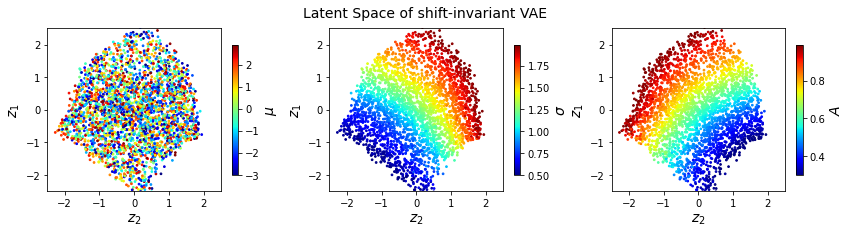

In [26]:
z_mean, z_sd = tvae.encode(train_data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Latent Space of shift-invariant VAE", fontsize = 14)
fig.subplots_adjust(wspace = 0.3)

im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=mu_real, cmap = 'jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2.5, 2.5)
ax1.set_ylim(-2.5, 2.5)

im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=sig_real, cmap = 'jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2.5, 2.5)
ax2.set_ylim(-2.5, 2.5);

im3 = ax3.scatter(z_mean[:, -1], z_mean[:, -2], s=3, c=a_real, cmap = 'jet')
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_1$", fontsize=14)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$A$", fontsize=14)
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5);

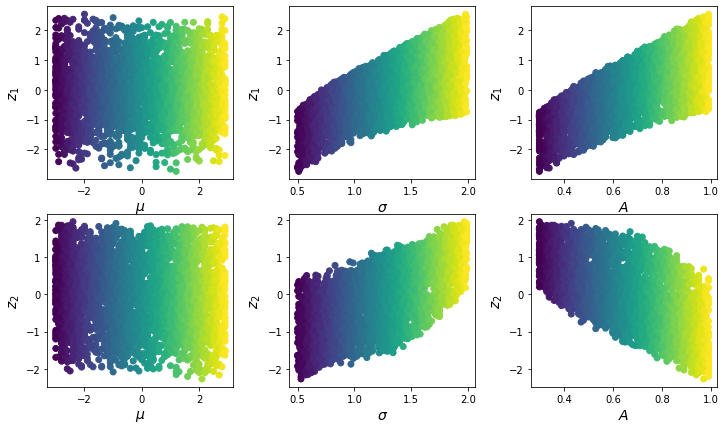

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(wspace = 0.3)

ax[0, 0].scatter(mu_real, z_mean[:, -2], c=mu_real)
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("$z_1$", fontsize=14)
ax[1, 0].scatter(mu_real, z_mean[:, -1], c=mu_real)
ax[1, 0].set_xlabel("$\mu$", fontsize=14)
ax[1, 0].set_ylabel("$z_2$", fontsize=14)

ax[0, 1].scatter(sig_real, z_mean[:, -2], c=sig_real)
ax[0, 1].set_xlabel("$\sigma$", fontsize=14)
ax[0, 1].set_ylabel("$z_1$", fontsize=14)
ax[1, 1].scatter(sig_real, z_mean[:, -1], c=sig_real)
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("$z_2$", fontsize=14);

ax[0, 2].scatter(a_real, z_mean[:, -2], c=a_real)
ax[0, 2].set_xlabel("$A$", fontsize=14)
ax[0, 2].set_ylabel("$z_1$", fontsize=14)
ax[1, 2].scatter(a_real, z_mean[:, -1], c=a_real)
ax[1, 2].set_xlabel("$A$", fontsize=14)
ax[1, 2].set_ylabel("$z_2$", fontsize=14);

Plot shift-variable vs. ground truth

Text(0, 0.5, 'shift variable')

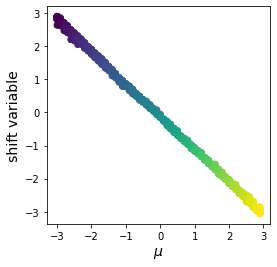

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(mu_real, z_mean[:, 0], c=mu_real)
ax.set_xlabel("$\mu$", fontsize=14)
ax.set_ylabel("shift variable", fontsize=14)